## Intro

Here, we will see the extrapolation potential - and problems - of neural networks. We have trained two simple networsk with one, 8-neuron hidden layer, to imitate the identity transformation on $x ~ N(0, 1)$. We'll see how well they perform outside that domain. (The only difference between them is the nonlinearity - one ELU, one ReLU).

In [1]:
from utils import *
from simple import *

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

fname = 'extrapolation'

datasize, learning_rate, epochs = get_params(fname)
print([datasize, learning_rate, epochs])

Le, Lre = get_losses(fname)

e, re = get_models(fname)

datasize,learning_rate,epochs

[2048, 0.001, 50000]


## Learning

First, let's take a look at the learning curves, to make sure that the net seems to have plateaued. To avoid wasting space, the first several losses won't be visible.

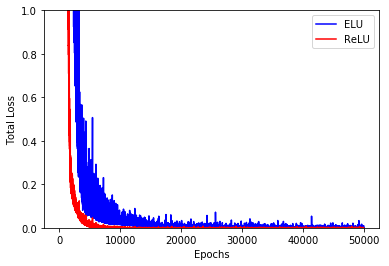

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
plt.plot(range(1, len(Le)+1), Le, 'b-', label="ELU")
plt.plot(range(1, len(Le)+1), Lre, 'r-', label="ReLU")
plt.ylim([0, 1])
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.legend()

fig

It appears that both losses have plateaued. Where?

In [3]:
print("ELU")
print(Le[-10:])
print("ReLU")
print(Lre[-10:])

ELU
[0.0017350653652101755, 0.001777201658114791, 0.0017947613960132003, 0.001500337035395205, 0.0016159869264811277, 0.001391374273225665, 0.0019472627900540829, 0.0016390711534768343, 0.001595130655914545, 0.008935989812016487]
ReLU
[2.9709661397703258e-09, 1.4931702541076675e-09, 3.1907516628848498e-09, 3.4615756927536268e-09, 3.199982945290003e-09, 3.332293996294311e-09, 3.0136293460714114e-09, 3.8847067784786304e-09, 1.2723193609787131e-09, 6.424778487001959e-10]


Great. Now, let's examin the behavior far from the training distribution

## Plots of The Function

In [4]:
# Get data and ground truth

x = np.arange(-10, 10, 0.01)
y = np.arange(-10, 10, 0.01)

In [5]:
# Compute network output

data = torch.FloatTensor(x.reshape(-1, 1)).cuda()

oe = e(data)
ore = re(data)

ye = oe.cpu().detach().numpy()
yre = ore.cpu().detach().numpy()

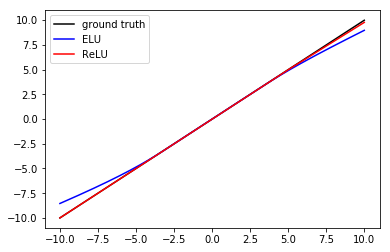

In [6]:
# Plot output

fig = plt.figure()

plt.plot(x, y, 'k-', label="ground truth")
plt.plot(x, ye, 'b-', label="ELU")
plt.plot(x, yre, 'r-', label="ReLU")

plt.legend()

fig

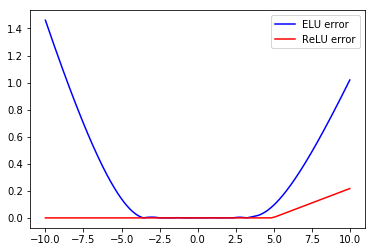

In [7]:
# Plot the L2 error

fig = plt.figure()

plt.plot(x, np.sqrt((ye.reshape(2000)-y)**2), 'b-', label="ELU error")
plt.plot(x, np.sqrt((yre.reshape(2000)-y)**2), 'r-', label="ReLU error")

plt.legend()

fig

Ther seems to be a significant error even here, for both networks, even though ReLU is far closer (about 2 percent).

Let's look at the internals of these networks in order to see where we can expect further errors.

In [8]:
print("ReLU")

print(re.fc1.weight)
print(re.fc1.bias)
print(-re.fc1.bias.view(-1, 1)/re.fc1.weight)

print("\n\n#######################\n\n")

print(re.fc2.weight)
print(re.fc2.bias)

ReLU
Parameter containing:
tensor([[-0.0986],
        [-1.3353],
        [ 1.2751],
        [-0.1639],
        [ 0.6900],
        [-1.0852],
        [-0.6144],
        [-0.6547]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.4987, -0.2520,  0.2409,  0.7899, -0.3336, -0.2055,  0.2972,  0.3164],
       device='cuda:0', requires_grad=True)
tensor([[ 5.0569],
        [-0.1888],
        [-0.1890],
        [ 4.8196],
        [ 0.4835],
        [-0.1893],
        [ 0.4837],
        [ 0.4833]], device='cuda:0', grad_fn=<DivBackward0>)


#######################


Parameter containing:
tensor([[-0.1661, -0.2742,  0.4259, -0.1607,  0.6003, -0.1631, -0.4095, -0.2484]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.3075], device='cuda:0', requires_grad=True)


Based on $ - b / w$, we see that between $-10$ and $+10$, we should scroll past all the "elbows" of the ReLU functions. What about the ELU?

In [9]:
print("ELU")

print(e.fc1.weight)
print(e.fc1.bias)
print(-e.fc1.bias.view(-1, 1)/e.fc1.weight)

print("\n\n#######################\n\n")

print(e.fc2.weight)
print(e.fc2.bias)

ELU
Parameter containing:
tensor([[ 0.4577],
        [ 0.2959],
        [ 0.3581],
        [-0.4150],
        [ 0.2957],
        [-0.3968],
        [-0.4066],
        [-0.5108]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.4937,  1.0163, -1.3615, -1.0884, -1.1240,  0.9984,  0.2869, -0.5215],
       device='cuda:0', requires_grad=True)
tensor([[-1.0788],
        [-3.4347],
        [ 3.8027],
        [-2.6225],
        [ 3.8005],
        [ 2.5161],
        [ 0.7056],
        [-1.0208]], device='cuda:0', grad_fn=<DivBackward0>)


#######################


Parameter containing:
tensor([[ 0.3118,  0.9333,  0.2469, -0.5600,  0.8370, -0.7382, -0.2792,  0.0280]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.1028], device='cuda:0', requires_grad=True)


ELU too. So, there is no need to scroll further; it seems that the linear behavior we currently see is going to be assymptotic towards infinity. Let's still plot that behavior, however.

In [10]:
# Get data and ground truth

x = np.arange(-1000, 1000, 1.)
y = np.arange(-1000, 1000, 1.)

In [11]:
# Compute network output

data = torch.FloatTensor(x.reshape(-1, 1)).cuda()

oe = e(data)
ore = re(data)

ye = oe.cpu().detach().numpy()
yre = ore.cpu().detach().numpy()

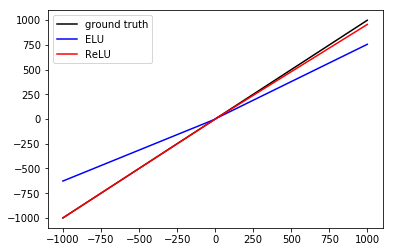

In [12]:
# Plot output

fig = plt.figure()

plt.plot(x, y, 'k-', label="ground truth")
plt.plot(x, ye, 'b-', label="ELU")
plt.plot(x, yre, 'r-', label="ReLU")

plt.legend()

fig

/nfs01/shared_software/anaconda3/envs/artem/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


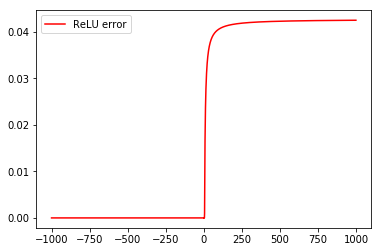

In [13]:
# Focus only on ReLU

fig = plt.figure()

plt.plot(x, np.sqrt((yre.reshape(2000)-y)**2)/abs(y), 'r-', label="ReLU error")

plt.legend()

fig

/nfs01/shared_software/anaconda3/envs/artem/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


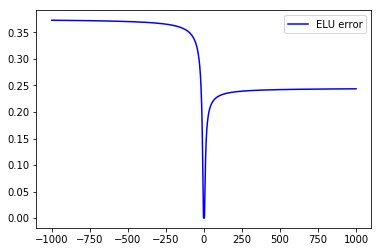

In [14]:
# Focus only on ELU

fig = plt.figure()

plt.plot(x, np.sqrt((ye.reshape(2000)-y)**2)/abs(y), 'b-', label="ELU error")

plt.legend()

fig

## Concluding Thoughts

ReLU had an admirably low error, but still not exactly $0$ - an error of 4 percent. We see that reliable extrapolation isn't really possible, even for the simplest funcitons.